In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import dataset
assert tf.config.list_physical_devices('GPU')


Using TensorFlow backend.


In [2]:
MAXLEN = 64
BATCH_SIZE = 32

def build_model():
    EMBED_DIM = 512
    UNITS = 256

    NIQQUD_SIZE = len(dataset.niqqud_table)
    DAGESH_SIZE = len(dataset.dagesh_table)
    LETTERS_SIZE = len(dataset.letters_table)

    common_input = tf.keras.Input(batch_shape=(None, MAXLEN), batch_size=BATCH_SIZE)
    common = layers.Embedding(LETTERS_SIZE, EMBED_DIM, mask_zero=True)(common_input)
    common = layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)

    common = layers.add([common, layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)])

    niqqud = layers.Softmax(name='N')(layers.Dense(NIQQUD_SIZE)(common))
    dagesh = layers.Softmax(name='D')(layers.Dense(DAGESH_SIZE)(common))

    model = tf.keras.Model(inputs=[common_input], outputs=[niqqud, dagesh])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    tf.keras.utils.plot_model(model, to_file='model.png')
    model.summary()
    return model
    
model = build_model()

def fit(data, learning_rates):
    return model.fit(data.normalized_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=len(learning_rates),
          validation_data=(data.normalized_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: learning_rates[epoch], verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 512)      22016       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 64, 256)      1574912     embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64, 256)      1050624     bidirectional[0][0]              
________

In [3]:
rabanit = ['birkat_hamazon.txt', 'hakdama_leorot.txt', 'hartzaat_harav.txt', 'orhot_hayim.txt', 'rambam_mamre.txt', 'short_table.txt', 'tomer_dvora.txt', 'breslev.txt']
modern = ['sipurim.txt' ,'atar_hashabat.txt', 'kakun.txt', 'sisters.txt', 'treasure_island.txt', 'ali_baba.txt', 'people.txt', 'ricky.txt', 'imagination.txt', 'adamtsair.txt', 'katarsis.txt']

def load_data(source):
    filenames = ['texts/' + f for f in source]
    return dataset.load_file(filenames, BATCH_SIZE, 0.2, maxlen=MAXLEN, shuffle=True)

data_rabanit = load_data(rabanit)
data_modern = load_data(modern)

In [4]:
history = fit(data_rabanit, [2e-3])
model.save_weights('./checkpoint_rabanit') 

Train on 69273 samples, validate on 17319 samples
69273/69273 [==============================] - 102s 1ms/sample - loss: 0.2916 - N_loss: 0.2343 - D_loss: 0.0573 - N_accuracy: 0.9185 - D_accuracy: 0.9780 - val_loss: 0.1419 - val_N_loss: 0.1107 - val_D_loss: 0.0311 - val_N_accuracy: 0.9629 - val_D_accuracy: 0.9887


In [5]:
model.load_weights('./checkpoint_rabanit')
history = fit(data_modern, [2e-3])

Train on 6630 samples, validate on 1658 samples
6630/6630 [==============================] - 9s 1ms/sample - loss: 0.2560 - N_loss: 0.2006 - D_loss: 0.0556 - N_accuracy: 0.9349 - D_accuracy: 0.9776 - val_loss: 0.1995 - val_N_loss: 0.1541 - val_D_loss: 0.0454 - val_N_accuracy: 0.9510 - val_D_accuracy: 0.9816


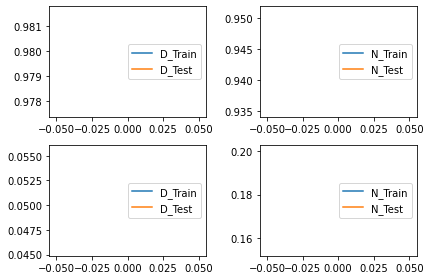

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [7]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '.')

In [8]:
def print_predictions(data, k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.normalized_validation[s]
    prediction = model.predict(batch)
    [actual_niqqud, actual_dagesh] = [dataset.from_categorical(prediction[0]), dataset.from_categorical(prediction[1])]
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        print()

print_predictions(data_modern, 1)

מצוי:  חָבֵר?" הִצִיעָה לִפְעָמִים אִמָּא שֶלוֹ, אֲבָל אַלוֹן אָמַר לָהּ שֶיֵּש לוֹ הָמוֹן חֲבֵרִים
רצוי:  חָבֵר?" הִצִיעָה לִפְעָמִים אִמָא שֶלוֹ, אֲבָל אַלוֹן אָמַר לָה שֶיֵש לוֹ הֲמוֹן חֲבֵרִים

מצוי:  מִישֶהוּ עָצַר בּוֹ כַּנִרְאֶה, וְקוֹלוֹ שֶל הֶנְדְס דָבָר: "אוֹף, תַּפְסִיק אֶת זֶה! לָמָה
רצוי:  מִישֶהוּ עָצַר בּוֹ כַּנִרְאֶה, וְקוֹלוֹ שֶל הֶנְדְס דִבֵּר: "אוּף, תַּפְסִיק אֶת זֶה! לָמָה

מצוי:  נִמְצָא הָאוֹצָר שֶל פְלִינְט. בּוֹאוּ נֵרַד לַחוֹף לִמְצֹא אוֹתוֹ'. הַקֶפְּטְן לֹא רָצָה,
רצוי:  נִמְצָא הָאוֹצָר שֶל פְלִינְט. בּוֹאוּ נֵרֵד לַחוֹף לִמְצֹא אוֹתוֹ'. הַקֶפְּטְן לֹא רָצָה,

מצוי:  הַבִּקָשָה הַזּוֹ, וְלֹא יָדַע אֵיךְ לְהַגִיב. הוּא הִסְבִּיר לְאַנְשֵי הַקְהִלָה שֶאֵין לוֹ שוּם
רצוי:  הַבַּקָּשָה הַזּוֹ, וְלֹא יָדַע אֵיךְ לְהָגִיב. הוּא הִסְבִּיר לְאַנְשֵי הַקְּהִלָּה שֶאֵין לוֹ שוּם

מצוי:  שֶשְנֵי אַנְשֵי הַצֶוֶת הָאַחֲרוֹנִים - וְג'וֹן סִילְבֶר בֵּינֵיהֶם - הִגִיעוּ בְּסִירָה מִן
רצוי:  שֶשְנֵי אַנְשֵי הַצֶוֶת הָאַחֲרוֹנִים - וְג'וֹן סִילְבֶר בֵּינֵיהֶם - הִגִיעוּ בְּסִ